# Analysis Overview

This notebook includes a general overview of the dataset by (1) preparing your workspace to use the dataset in the COCO format, (2) visualizing a few images from one of the datasets for information purposes, and (3) conducting an analysis on modifications made to the Faster R-CNN model.  The dataset used is the SARscope dataset found at the below link.  The objective of this project is to determine whether proposed image processing methods would increase the performance of different models on Synthetic Aperture Radar data of maritime vessels.

Dataset: https://www.kaggle.com/datasets/kailaspsudheer/sarscope-unveiling-the-maritime-landscape

## Section 1 - Workspace Preparation

To ensure that the user can run this notebook without issue, please do the following:

1. Ensure your Python installtion is 3.8.10 or higher.
2. You are using the pip3 package manager.
3. Run the below installation steps. These are all the packages used in this notebook.

In [ ]:
# %pip3 install torch
# %pip3 install torchvision
# %pip3 install torchmetrics
# %pip3 install kagglehub
# %pip3 install json
# %pip3 install matplotlib
# %pip3 install cv2
# %pip install pycocotools
# %pip install utils

: 

In [1]:
# Utility Imports
import os, sys
import pathlib

# Data Handling Imports
from SeaSarFRCNN import SeaSarFRCNN
from ModelWorker import ModelWorkerFRCNN
from WorkspaceManager import WorkspaceManager

# Data & Model Imports
import torchvision
import torch

project_path = pathlib.Path.cwd().parent.resolve()
print(f"Project path: {project_path}")

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR


/home/jag1799/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Section 2 - Dataset Loading

### Section 2.1: Note on Kagglehub

Kagglehub does not natively support downloading to specific directories on the user's file system.  It instead downloads it to a cache folder, which may vary between users.  Thus, the below script moves all downloads will move the dataset folder to the included */data* folder in this repo.

If you have an error, this is likely due to the `shutil.move()` command failing because it sees the dataset still cached.  To counteract this, `cd` into the cache directory that is printed in the output and delete the entire data folder.  Then run this block again.  See Section 2.2 and the below code block comments for additional information.

### Section 2.2: Deleting the Cache

To re-download the dataset, you need to remove both the formatted folder in this repo's data directory (the *kaggle* folder) and the *kailaspsudheer* folder in the cache.

I recommend you run the *WorkspaceManager* setup block below with *clear_cache* off first, then manually delete it if you need to.  After you know where your cache is and confirm it's deleting the right directory, you can turn it on.

In [2]:
workspace_builder = WorkspaceManager()
workspace_builder.run_setup()

if not os.path.exists(workspace_builder._data_path):
    raise FileNotFoundError(f"Not able to find data directory at path: {workspace_builder._data_path}")
else:
    print(f"Using data path: {workspace_builder._data_path}")

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR
Found existing data path at /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle
Using data path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope


## Section 3 - Data Visualization

Below, we visualize a few randomly selected images throughout the validation dataset as examples of the different types of images the models will encounter and to ensure the annotations are working as expected.  All targets have the same category Id and category name: (1, "ship").

In [3]:
# Validation Path retrieval
tester_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_annotations = os.path.join(workspace_builder._data_path, "annotations", "train_annotations.coco.json")
train_images = os.path.join(workspace_builder._data_path, "train")

train_data = SeaSarFRCNN(train_images, train_annotations, tester_transforms)

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


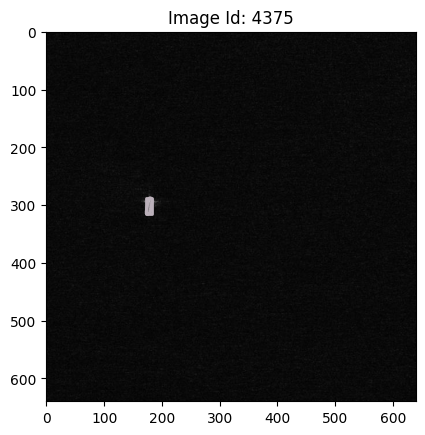

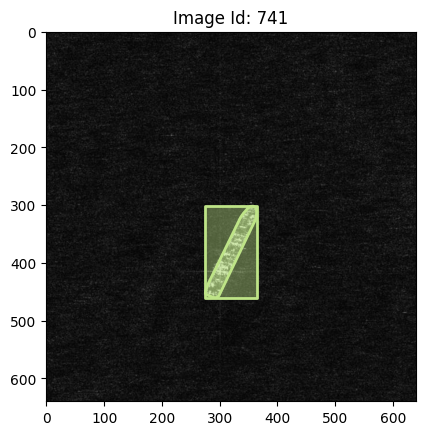

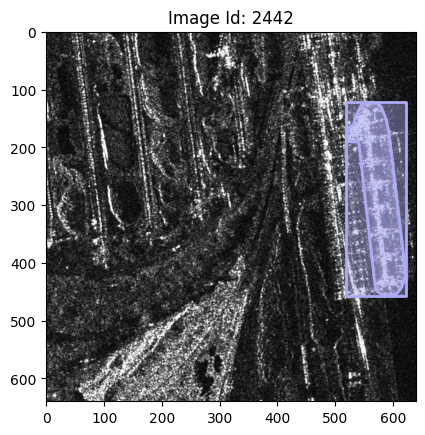

In [4]:
# Display 3 randomly selected images throughout the validation dataset with their annotations.
for i in range(3):
    train_data.show_random_image()

## Section 4 - Faster R-CNN

This section begins the analysis of different layer additions and modifications to the Faster R-CNN model.  Each section contains the following sub-sections for reference:

1. Data Preparation
2. Model Construction
3. Training
4. Testing & Analysis

### Section 4.1 - Baseline FRCNN

This section is to establish the baseline performance of an unmodified FRCNN model on our dataset.

#### Section 4.1.1 - Data Preparation

In [5]:
# Set up train dataloader
train_data = torchvision.datasets.wrap_dataset_for_transforms_v2(train_data, target_keys=("boxes", "labels"))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False, collate_fn=train_data._packager, num_workers=1)

In [6]:
validation_annotations = os.path.join(workspace_builder._data_path, "annotations", "valid_annotations.coco.json")
validation_images = os.path.join(workspace_builder._data_path, "valid")
validation_data = SeaSarFRCNN(validation_images, validation_annotations, transform=tester_transforms)
validation_data = torchvision.datasets.wrap_dataset_for_transforms_v2(validation_data, target_keys=("boxes", "labels"))
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=False, collate_fn=validation_data._packager, num_workers=1)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


#### Section 4.1.2 - Model Setup

In [7]:
# Build the baseline model
frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
input_features = frcnn.roi_heads.box_predictor.cls_score.in_features
frcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, 2)

# Build the loss function and optimizer
optimizer = torch.optim.Adam(frcnn.parameters(), lr=0.001)

/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Section 4.1.3 - Baseline Training & Validation

When running training, be advised that you may need to close other programs, completely kill your Jupyter Kernel, or restart VSCode.  FRCNN and Pytorch consume significant amounts of memory per run and remain allocated in the background on your GPU.  After enough times running train/validation cells, the program will fail saying CUDA is out of memory.  This is when you must either manually kill background programs from the terminal or restart VSCode.  Below are the instructions to determine which programs to kill.

**NOTE**: These instructions were written for Ubuntu Linux 20.04.  Your steps may differ slightly.

1. Open a terminal window
2. Assuming you have CUDA set up, enter the "*nvidia-smi*" command.  This will display all processes currently using your GPU.
3. Run *sudo fuser -v /dev/nvidia\**.  This will display another list of process also using your GPU, including the owner of said process.
    - This step is to differentiate between your processes and system processes.  
    - **DO NOT EVER KILL A SYSTEM PROCESS USING THESE STEPS. IF IT IS CAUSING PROBLEMS, RESTART YOUR COMPUTER AND THIS CAN SAFELY REFRESH ALL PROCESSES USING YOUR GPU.**
4. Identify all processes owned by you and get their PIDs.
5. Refer back to the *nvidia-smi* table on which PID is consuming the most memory.
6. Do one of the following:
    - If possible, close the process normally like a Firefox window.
    - Run *sudo kill -9 "your_PID"*.

In [ ]:
# Do training and validation
worker = ModelWorkerFRCNN(train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, optimizer=optimizer, frcnn=frcnn, quiet=False)
worker.train(1, [3736])

In [ ]:
# Run Validation
worker.validation(1)

Failed on Batch 235atch Loss: 0.254693359136581463
Image: (tensor([[[0.0510, 0.0314, 0.0157,  ..., 0.0314, 0.0235, 0.0431],
         [0.0588, 0.0431, 0.0314,  ..., 0.0549, 0.0549, 0.0667],
         [0.0353, 0.0314, 0.0314,  ..., 0.0549, 0.0588, 0.0549],
         ...,
         [0.0392, 0.0392, 0.0353,  ..., 0.0353, 0.0353, 0.0314],
         [0.0392, 0.0392, 0.0392,  ..., 0.0314, 0.0275, 0.0235],
         [0.0353, 0.0353, 0.0392,  ..., 0.0314, 0.0235, 0.0196]],

        [[0.0510, 0.0314, 0.0157,  ..., 0.0314, 0.0235, 0.0431],
         [0.0588, 0.0431, 0.0314,  ..., 0.0549, 0.0549, 0.0667],
         [0.0353, 0.0314, 0.0314,  ..., 0.0549, 0.0588, 0.0549],
         ...,
         [0.0392, 0.0392, 0.0353,  ..., 0.0353, 0.0353, 0.0314],
         [0.0392, 0.0392, 0.0392,  ..., 0.0314, 0.0275, 0.0235],
         [0.0353, 0.0353, 0.0392,  ..., 0.0314, 0.0235, 0.0196]],

        [[0.0510, 0.0314, 0.0157,  ..., 0.0314, 0.0235, 0.0431],
         [0.0588, 0.0431, 0.0314,  ..., 0.0549, 0.0549, 0.0667],

RuntimeError: DataLoader worker (pid(s) 33958) exited unexpectedly

#### Section 4.1.4 - Baseline Testing

In [ ]:
test_images = os.path.join(workspace_builder._data_path, "test")
test_annotations = os.path.join(workspace_builder._data_path, "annotations", "test_annotations.coco.json")
test_data = SeaSarFRCNN(test_images, test_annotations, transform=tester_transforms)
test_data = torchvision.datasets.wrap_dataset_for_transforms_v2(test_data, target_keys=("boxes", "labels"))
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, collate_fn=test_data._packager, num_workers=4)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
worker.model_test(test_dataloader, False)

[{'boxes': tensor([[5.7533e+02, 2.9506e+02, 6.4000e+02, 3.9759e+02],
        [5.7496e+02, 3.2121e+02, 6.0054e+02, 3.4790e+02],
        [5.8396e+02, 3.2122e+02, 6.0981e+02, 3.4733e+02],
        [5.9372e+02, 3.2142e+02, 6.1966e+02, 3.4765e+02],
        [6.0986e+02, 3.1815e+02, 6.3578e+02, 3.4413e+02],
        [5.8497e+02, 3.2846e+02, 6.3548e+02, 3.7964e+02],
        [5.8604e+02, 2.9726e+02, 6.1091e+02, 3.2318e+02],
        [6.1045e+02, 2.9667e+02, 6.3566e+02, 3.2251e+02],
        [3.2728e+02, 5.6463e+02, 3.7690e+02, 6.1577e+02],
        [4.4785e+02, 2.3174e+02, 4.9853e+02, 2.8311e+02],
        [5.9274e+02, 2.0472e+02, 6.1804e+02, 2.3107e+02],
        [5.8003e+02, 2.0486e+02, 6.0532e+02, 2.3111e+02],
        [1.9715e+01, 5.9009e+02, 7.0513e+01, 6.4000e+02],
        [9.0291e+01, 2.8992e+02, 1.4153e+02, 3.3974e+02],
        [7.9005e+01, 1.4262e+02, 1.2891e+02, 1.9291e+02],
        [2.7779e+02, 5.2048e+02, 3.2666e+02, 5.7104e+02],
        [1.1773e-02, 6.1196e+02, 1.6551e+01, 6.3793e+02],
   